In [1]:
# regularized_jump_model_demo.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import optuna
from typing import Optional, List, Dict, Tuple

# Add the current directory to Python path to import your modules
sys.path.append('.')

# Import your custom modules
from Datafactory import normalized, load_feature_data
from Jump_New import RegularizedJumpModel, PenaltyType

# Optional: If you get import errors, use this alternative approach
import importlib.util
import os

c:\Users\Lucas YY\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DataLoading

In [2]:
def load_your_data(file_path):
    """
    Load your feature data from Excel file
    """
    try:
        df = load_feature_data(file_path, 0)
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    
df = load_your_data('top_features_df.csv')
performance = []

Data loaded successfully. Shape: (421, 41)
Columns: ['IPNCONGD', 'INDPRO', 'IPNMAT', 'IPB51222S', 'IPFUELS', 'UEMPMEAN', 'USFIRE', 'UEMP27OV', 'UEMP15OV', 'CES0600000008', 'HOUST', 'AMDMUOx', 'DPCERA3M086SBEA', 'UMCSENTx', 'BUSINVx', 'M2SL', 'DTCTHFNM', 'TOTRESNS', 'NONREVSL', 'BOGMBASE', 'EXJPUSx', 'EXSZUSx', 'TB3MS', 'FEDFUNDS', 'COMPAPFFx', 'CUSR0000SAS', 'WPSFD49207', 'DDURRG3M086SBEA', 'WPSID62', 'CUSR0000SAD', 'S&P div yield', 'S&P PE ratio', 'GDP_diff', 'CAPE', 'MOVE Index', 'VIX Index', 'USGG2YR Index', 'LUACOAS Index', '.0210 F Index', 'SPX_realized_vol_20d', 'SPX_realized_vol_60d']


In [3]:
import yfinance as yf
spx = yf.download("^GSPC", start = '1990-01-01', end = '2025-04-01', auto_adjust=True, progress=False)  # 日频
prices = spx["Close"].dropna()

(              mean_monthly_return  mean_intra_month_vol  count_months
asset regime                                                         
asset 1              3.633686e+73             16.894982           121
      2              3.173339e+75             35.314596            65
      3              3.757829e+84             34.839471            94
      4              5.806842e+81             32.533554           140,                                             mean_monthly_return  \
asset regime                                                      
asset 1       3633686064585063106718390105753444680149889493...   
      2       3173339336031480089008696885068873972760790312...   
      3       3757828811884310841766464431443628318291160981...   
      4       5806842240987673456751568935702617253446735651...   

             mean_intra_month_vol  count_months  
asset regime                                     
asset 1                  1689.50%           121  
      2                  

c:\Users\Lucas YY\capstone_vanguard\Yichen\Jump_New.py:817: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_ret = (1.0 + r).resample("M").apply(np.prod) - 1.0
c:\Users\Lucas YY\capstone_vanguard\Yichen\Jump_New.py:817: FutureWarning: The provided callable <function prod at 0x000001C6A703D3A0> is currently using DatetimeIndexResampler.prod. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "prod" instead.
  m_ret = (1.0 + r).resample("M").apply(np.prod) - 1.0
c:\Users\Lucas YY\capstone_vanguard\Yichen\Jump_New.py:819: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  intra_month_vol = r.resample("M").std()


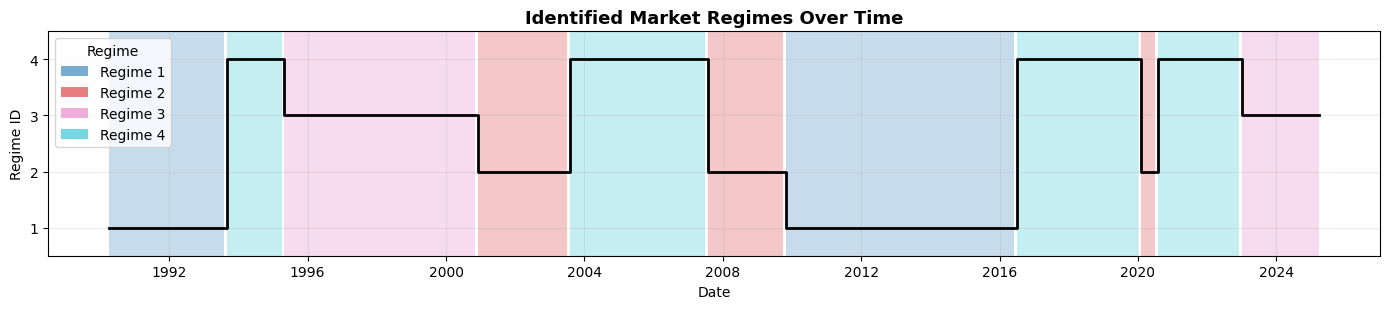

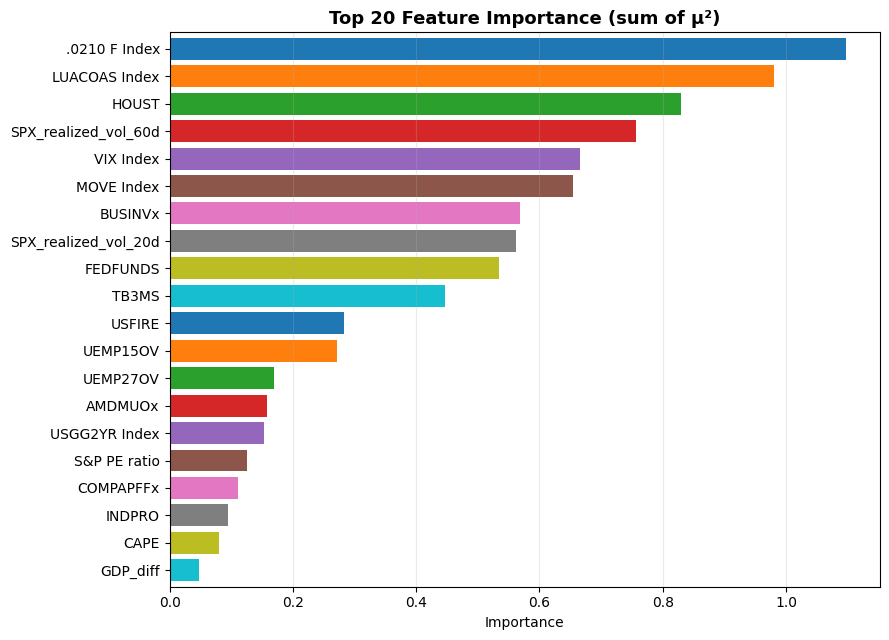

In [4]:
model = RegularizedJumpModel(
    k=4,           # Number of states
    lmbd=20,     # Jump penalty parameter
    gamma=0.1,   # Regularization parameter
    penalty="ridge"  # Penalty type: "l0", "lasso", "ridge", "group_lasso"
)
df = df.dropna(axis=0, how='any')
sample_data = normalized(df)
model.input_data(sample_data)
model.initialize()
model.calibrate()
model.visualize()
print(model.summarize_by_regime_from_daily_returns(prices))

In [5]:
# def run_complete_analysis_with_optuna(
#     data: pd.DataFrame,
#     base_model,
#     random_state: int = 42,
#     calibrate_max_iter: int = 10,
#     # pass through to optuna_tune_with_bootstrap:
#     lambda_range: tuple = (1e-1, 1e2),
#     gamma_range: tuple = (1e-1, 1e2),
#     penalty_candidates: List[str] = ("lasso", "l0", "ridge", "group_lasso"),
#     n_boot: int = 10,
#     n_trials: int = 60,
#     sampler: Optional[optuna.samplers.BaseSampler] = None,
#     pruner: Optional[optuna.pruners.BasePruner] = None,
#     storage: Optional[str] = None,
#     study_name: Optional[str] = None,
#     n_startup_trials: int = 10,
# ) -> dict:
#     """
#     End-to-end pipeline:
#       1) Tune hyperparameters with optuna_tune_with_bootstrap (across all percents).
#       2) Rebuild a model with best params.
#       3) Initialize, restrict to best_percent, calibrate.
#       4) Compute metrics and feature importance; return a results bundle.
#     """

#     def _pick_nearest_key(keys, target):
#         """Pick exact or nearest percent key from `keys`."""
#         if target in keys:
#             return target
#         try:
#             t = float(target)
#             return min(((abs(float(k) - t), k) for k in keys), key=lambda x: x[0])[1]
#         except Exception:
#             return next(iter(keys))

#     def _score_solution(y_np: np.ndarray, mu, s: np.ndarray,
#                         lmbd: float, gamma: float, model_like) -> dict:
#         """Compute original-data cost components and total. Accepts mu as DF or ndarray."""
#         if mu is None or s is None:
#             return {"recon_error": np.inf, "jumps": np.inf, "reg": np.inf, "total_cost": np.inf}
#         mu_arr = mu.to_numpy() if isinstance(mu, pd.DataFrame) else np.asarray(mu)
#         recon_error = float(np.sum((y_np - mu_arr[s - 1]) ** 2))
#         jumps = int(np.sum(s[1:] != s[:-1]))
#         reg = float(model_like.compute_penalty(mu))  # model can handle DF or ndarray
#         total_cost = recon_error + float(lmbd) * jumps + float(gamma) * reg
#         return {"recon_error": recon_error, "jumps": jumps, "reg": reg, "total_cost": total_cost}

#     def _compute_importance_by_feature(mu, data: pd.DataFrame, model_like) -> pd.Series:
#         """
#         Per-feature importance = sum over states of mu^2 for each feature.
#         Returns a pd.Series indexed by feature names.
#         """
#         if isinstance(mu, pd.DataFrame):
#             return (mu ** 2).sum(axis=0)  # columns are feature names
#         # ndarray path
#         mu_arr = np.asarray(mu)
#         names = getattr(model_like, "feature_names", None)
#         if names is None:
#             try:
#                 names = list(data.columns)
#             except Exception:
#                 names = [f"f{j}" for j in range(mu_arr.shape[1])]
#         return pd.Series(np.sum(mu_arr ** 2, axis=0), index=names)

#     results: dict = {}

#     # 1) Tuning
#     print("\n[1] Tuning with optuna_tune_with_bootstrap ...")
#     tuner = RegularizedJumpModel(k=base_model.k, lmbd=base_model.lmbd,
#                                  gamma=base_model.gamma, penalty=base_model.penalty)
#     tuner.input_data(data)
#     tune_out = tuner.optuna_tune_with_bootstrap(
#         lambda_range=lambda_range,
#         gamma_range=gamma_range,
#         penalty_candidates=list(penalty_candidates),
#         n_boot=n_boot,
#         max_iter=calibrate_max_iter,
#         n_trials=n_trials,
#         random_state=random_state,
#         sampler=sampler,
#         pruner=pruner,
#         storage=storage,
#         study_name=study_name,
#         n_startup_trials=n_startup_trials,
#     )

#     best_params = tune_out["best_params"]
#     best_percent = tune_out["best_percent"]
#     best_score = tune_out["best_score"]
#     print(f"   -> best_params   : {best_params}")
#     print(f"   -> best_percent  : {best_percent}")
#     print(f"   -> best_score    : {best_score:.6g}")

#     # 2) Build final model
#     print("\n[2] Building final model with tuned params ...")
#     final_model = RegularizedJumpModel(
#         k=base_model.k,
#         lmbd=best_params["lmbd"],
#         gamma=best_params["gamma"],
#         penalty=best_params["penalty"],
#     )

#     # 3) Initialize, restrict, calibrate
#     print("\n[3] Initializing and calibrating on full data ...")
#     final_model.input_data(data)
#     final_model.initialize(k=final_model.k, random_state=random_state)

#     chosen_key = _pick_nearest_key(final_model.initial_state.keys(), best_percent)
#     final_model.initial_state = {chosen_key: final_model.initial_state[chosen_key]}
#     calib = final_model.calibrate(max_iter=calibrate_max_iter)
#     best_res = calib[chosen_key]

#     # Persist best solution on the model
#     final_model.mu = best_res["mu"]
#     final_model.state_seq = best_res["state_sequence"]

#     # 4) Score + feature importance
#     print("\n[4] Scoring final solution + computing feature importance ...")
#     Y = final_model.data.to_numpy()
#     metrics = _score_solution(
#         y_np=Y,
#         mu=best_res["mu"],
#         s=best_res["state_sequence"],
#         lmbd=final_model.lmbd,
#         gamma=final_model.gamma,
#         model_like=final_model,
#     )
#     importance_by_feature = _compute_importance_by_feature(best_res["mu"], data, final_model)

#     print("\nFinal Model Summary")
#     print("=" * 60)
#     print(f"  percent          : {chosen_key}")
#     print(f"  iterations       : {best_res['iterations']}")
#     # Report shape whether mu is DF or ndarray
#     mu_shape = best_res["mu"].shape if not isinstance(best_res["mu"], pd.DataFrame) \
#                else (best_res["mu"].shape[0], best_res["mu"].shape[1])
#     print(f"  mu shape         : {mu_shape}")
#     print(f"  lambda (lmbd)    : {final_model.lmbd}")
#     print(f"  gamma            : {final_model.gamma}")
#     print(f"  penalty          : {getattr(final_model.penalty, 'value', str(final_model.penalty))}")
#     print(f"  recon_error      : {metrics['recon_error']:.6g}")
#     print(f"  jumps            : {metrics['jumps']}")
#     print(f"  reg (penalty)    : {metrics['reg']:.6g}")
#     print(f"  TOTAL COST       : {metrics['total_cost']:.6g}")

#     # Print top-20 features by importance
#     print("\nTop 20 features by importance (sum of μ² across states):")
#     print(importance_by_feature.sort_values(ascending=False).head(20).to_string())

#     # Bundle outputs
#     results["tuning"] = {
#         "best_params": best_params,
#         "best_score": best_score,
#         "best_percent": best_percent,
#         "study": tune_out.get("study"),
#     }
#     results["final"] = {
#         "percent": chosen_key,
#         "mu": best_res["mu"],                          # DF or ndarray
#         "state_sequence": best_res["state_sequence"],
#         "iterations": best_res["iterations"],
#         "metrics": metrics,
#         "importance_by_feature": importance_by_feature,  # <-- added
#         "feature_importance_init": getattr(final_model, "feature_score", None),  # from initialize
#         "model": final_model,
#     }
#     return results


# print("Starting RJM analysis with Optuna tuning ...")
# out = run_complete_analysis_with_optuna(
#     data=df,
#     base_model=model,
#     random_state=42,
#     calibrate_max_iter=10,
#     n_boot=10,
#     n_trials=60,
# )

(<Figure size 1400x320 with 1 Axes>, <Figure size 900x650 with 1 Axes>)

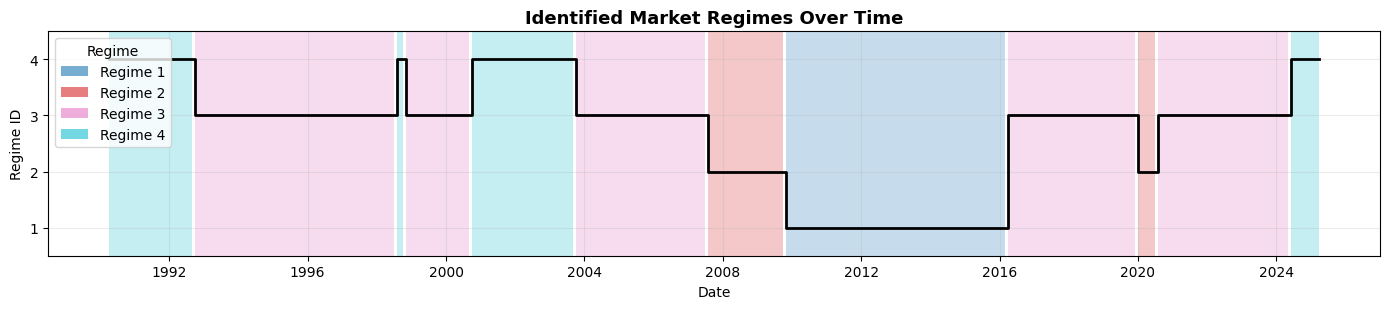

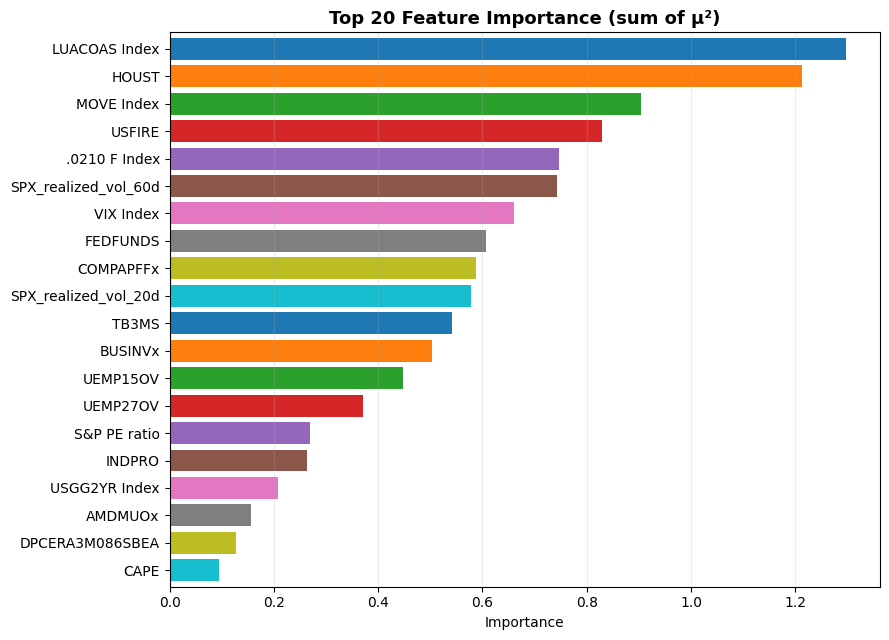

In [ ]:
model = RegularizedJumpModel(
    k=4,           # Number of states
    lmbd=20,     # Jump penalty parameter
    gamma=0.1,   # Regularization parameter
    penalty="ridge"  # Penalty type: "l0", "lasso", "ridge", "group_lasso"
)

# Split data into in-sample (IS) and out-of-sample (OOS) sets
train_end_date = '2019-12-31'
oos_start_date = '2020-01-01'

# Ensure the data index is a datetime index
df.index = pd.to_datetime(df.index)

# Split the data
train_data = df[df.index <= train_end_date]
oos_data = df[df.index >= oos_start_date]

# Initialize and calibrate the model using in-sample data
model.input_data(train_data)
model.initialize()
model.calibrate()

IS_regime = model.regime_series

# Test the model on out-of-sample data
# Use the frozen parameters (mu and s from training)
oos_regimes = model.predict(oos_data)  # OOS data
OOS_regime = model.regime_series

model.regime_series = pd.concat([IS_regime,OOS_regime])
model.visualize()